# Notes:

* remove a point so that each bin has exactly the same number of grid cells

In [1]:
import rasterio as rio
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import xarray as xr
from nlmpy import nlmpy
from datetime import datetime,timedelta
import pandas as pd
import seaborn as sns

In [2]:
tc = xr.open_dataset('tc.nc')
tc = tc.drop_vars(['precip','temp'])
streams = xr.open_dataset('usfs_streams.nc')
tcoords = np.arange(datetime.strptime('2005-10-01 00:00', "%Y-%m-%d %H:%M"),
                    datetime.strptime('2006-10-01 00:00', "%Y-%m-%d %H:%M"),
                    timedelta(hours=1)).astype(datetime)
wrf = xr.open_dataset('wrf.nc')
wrf['t'] = tcoords
outflow = xr.open_dataset('outflow.nc')
outflow['x'] = tc.x
outflow['y'] = tc.y
q = xr.Dataset()

In [3]:
def qmap(source,n):
    #source = source.where(~((source.x==5)&(source.y==58)))
    qv = source.quantile(np.arange(n+1)/n)
    #print(qv.values.tolist())
    qm = tc.okburn * n
    for i in np.arange(n-1):
        qm = qm.where(~((source >= qv[i])&(source < qv[i+1])),i+1)
    cells = [tc.okburn.where(qm==x).sum().values.tolist() for x in np.arange(n)+1]
    percs = [(tc.okburn.where(qm==x).sum()/tc.okburn.sum()).values.tolist() for x in np.arange(n)+1]
    vals = [str(x) for x in np.arange(1,n+1,1)]
    cp = zip(cells,percs)
    qm.attrs = dict(zip(vals,cp))
    qm = qm.where(qm>0)
    return qm

def stream_dist(sdmap):
    n = sdmap.max().values.tolist()
    ndist = (tc.mask.where(((sdmap + sdmap.shift(x=1) == n) | \
        (sdmap + sdmap.shift(x=-1) == n) | \
        (sdmap + sdmap.shift(y=1) == n) | \
        (sdmap + sdmap.shift(y=-1) == n)) & \
        (sdmap == 0),0) * tc.mask.where(tc.mask==1) * (n+2))
    nmap = sdmap + ndist
    return nmap

def perc_shared(v1,n1,v2,n2):
    v1count = tc.mask.where(v1==n1).sum().values.tolist()
    v2count = tc.mask.where(v2==n2).sum().values.tolist()
    shared = tc.mask.where((v1==n1)&(v2==n2)).sum().values.tolist()
    mcount = (v1count + v2count) / 2
    perc_shared = shared/mcount
    return perc_shared

def overlap(v1,v2):
    n1 = np.arange(1,v1.max().values.tolist()+1,1)
    n2 = np.arange(1,v2.max().values.tolist()+1,1)
    p = [perc_shared(v1,x,v2,y) for x in n1 for y in n2]
    x = [x for x in n1 for y in n2]
    y = [y for x in n1 for y in n2]
    df = pd.DataFrame()
    df[v1.name] = x
    df[v2.name] = y
    df['perc_shared'] = p
    mp = np.nanmax([df[df[v1.name]==n].perc_shared.max() for n in np.arange(1,6,1)])
    return mp

def overlap_table(ds):
    i = np.arange(len(ds.data_vars)).tolist()
    vlist = [x for x in ds.data_vars]
    vdict = dict(zip(vlist,i))
    otab = np.ones([len(ds.data_vars),len(ds.data_vars)])
    for x in ds.data_vars:
        for y in ds.data_vars:
            otab[vdict[x],vdict[y]] = overlap(ds[x],ds[y])
    da = xr.DataArray(otab,dims=['x','y'],name='overlap')
    da['x'] = vlist
    da['y'] = vlist
    df = da.to_dataframe().reset_index()
    return df

def feedtrace(da):
    from_north = tc.mask.where((da.shift(y=-1)>0)&(tc.aspect==1),0)
    from_east = tc.mask.where((da.shift(x=-1)>0)&(tc.aspect==2),0)
    from_south = tc.mask.where((da.shift(y=1)>0)&(tc.aspect==3),0)
    from_west = tc.mask.where((da.shift(x=1)>0)&(tc.aspect==4),0)
    feeders = from_north + from_east + from_south + from_west
    return feeders

def flow_trace(start):
    outfeed = start
    outfeed_iter = start
    i = 1
    while i > 0:
        outfeed_iter = feedtrace(outfeed_iter)
        if outfeed_iter.sum() > 0:
            i+=1
            outfeed = outfeed + outfeed_iter
        else:
            i=0
    return outfeed

def cperc(da):
    p = target/okburn.where(da==1,0).sum().values
    return p

In [4]:
# burn eligibility
err_out = tc.mask.where((outflow.overlandsum<outflow.overlandsum.max())&(outflow.overlandsum>0),0)
err_trace = flow_trace(err_out)
okburn = tc.mask.where(err_trace==0)
okburn = okburn.where(okburn==1,0)
tc['okburn'] = okburn
target = okburn.sum().values/5
tc.okburn.attrs = {'total cells': okburn.sum().values.tolist(),
          'burnt cells': target}

# random
q['random1'] = xr.DataArray(nlmpy.classifyArray(nlmpy.random(64,24,mask=okburn),[0.2,0.2,0.2,0.2,0.2])+1,dims=['y','x'])
q['random2'] = xr.DataArray(nlmpy.classifyArray(nlmpy.random(64,24,mask=okburn),[0.2,0.2,0.2,0.2,0.2])+1,dims=['y','x'])

# aspect (modified)
aspe = tc.aspect.where(tc.aspect==2)
iso1 = aspe.where((tc.x>20)&(tc.y<70),0)
aspe = aspe.where(iso1==0)
iso2 = aspe.where(((tc.x>15)&(tc.y<20))|((tc.x>17)&(tc.y>74)),0)
aspe = aspe.where(iso2==0)
aspe = tc.mask.where(aspe==2)
aspe = aspe.where(aspe==1,0)
aspw = tc.aspect.where(tc.aspect==4)
iso3 = aspw.where(((tc.x<=17)&(tc.y>40))|((tc.x<14)&(tc.y<40)&(tc.y>20)),0)
aspw = aspw.where(iso3==0)
aspw = tc.mask.where(aspw==4)
aspw = aspw.where(aspw==1,0)
aspn = tc.aspect.where((tc.aspect==1)|(tc.aspect==3))
aspn = aspn / aspn
aspn = aspn.where(aspn==1,0)
# apply okburn mask
aspe = aspe.where(okburn==1,0)
aspw = aspw.where(okburn==1,0)
aspn = aspn.where(okburn==1,0)
# classify
aspe_class = xr.DataArray(nlmpy.classifyArray(nlmpy.random(64,24,mask=aspe),[1-cperc(aspe),cperc(aspe)]),dims=['y','x'],name='e')
aspw_class = xr.DataArray(nlmpy.classifyArray(nlmpy.random(64,24,mask=aspw),[1-cperc(aspw),cperc(aspw)]),dims=['y','x'],name='w')
aspn_class = xr.DataArray(nlmpy.classifyArray(nlmpy.random(64,24,mask=aspn),[1-cperc(aspn),cperc(aspn)]),dims=['y','x'],name='ns')
aspe_class = aspe_class.where(aspe_class==1,0) * tc.mask * 1
aspw_class = aspw_class.where(aspw_class==1,0) * tc.mask * 2
aspn_class = aspn_class.where(aspn_class==1,0) * tc.mask * 3
q['aspect'] = aspe_class + aspw_class + aspn_class
q['aspect'] = q.aspect.where(q.aspect>0)

# elevation
q['elev'] = qmap(tc.dem.where(okburn==1),5)

# longwave
tc['longwave'] = wrf.longwave.mean(dim='t')*tc.mask.where(tc.mask==1)
q['longwave'] = qmap(tc.longwave.where(okburn==1),5)

# shortwave
tc['shortwave'] = wrf.shortwave.mean(dim='t')*tc.mask.where(tc.mask==1)
q['shortwave'] = qmap(tc.shortwave.where(okburn==1),5)

# temperature
tc['temp'] = wrf.temp.mean(dim='t')*tc.mask.where(tc.mask==1)
q['temp'] = qmap(tc.temp.where(okburn==1),5)

# precipitation
tc['precip'] = wrf.precip.mean(dim='t')*tc.mask.where(tc.mask==1)
q['precip'] = qmap(tc.precip.where(okburn==1),5)

# wind
tc['wind'] = (np.sqrt((wrf.wind_ew ** 2) + (wrf.wind_ns ** 2))).mean(dim='t')*tc.mask.where(tc.mask==1)
q['wind'] = qmap(tc.wind.where(okburn==1),5)

# specific humidity
tc['sphumid'] = wrf.sp_humid.mean(dim='t')*tc.mask.where(tc.mask==1)
q['sphumid'] = qmap(tc.sphumid.where(okburn==1),5)

# atmospheric pressure
tc['atmpress'] = wrf.atm_press.mean(dim='t')*tc.mask.where(tc.mask==1)
q['atmpress'] = qmap(tc.atmpress.where(okburn==1),5)

# slope
slope = abs(tc.slope) + np.random.uniform(low=0,high=0.001,size=np.shape(tc.slope))
q['slope'] = qmap(slope.where(okburn==1),5)

# distance from streams
sd = tc.streams
for i in np.arange(7):
    sd = stream_dist(sd)
sd = sd/2 + 0.5
tc['streamdist'] = sd
sd = sd + np.random.uniform(low=0,high=0.001,size=np.shape(sd))
q['streamdist'] = qmap(sd.where(okburn==1),5)

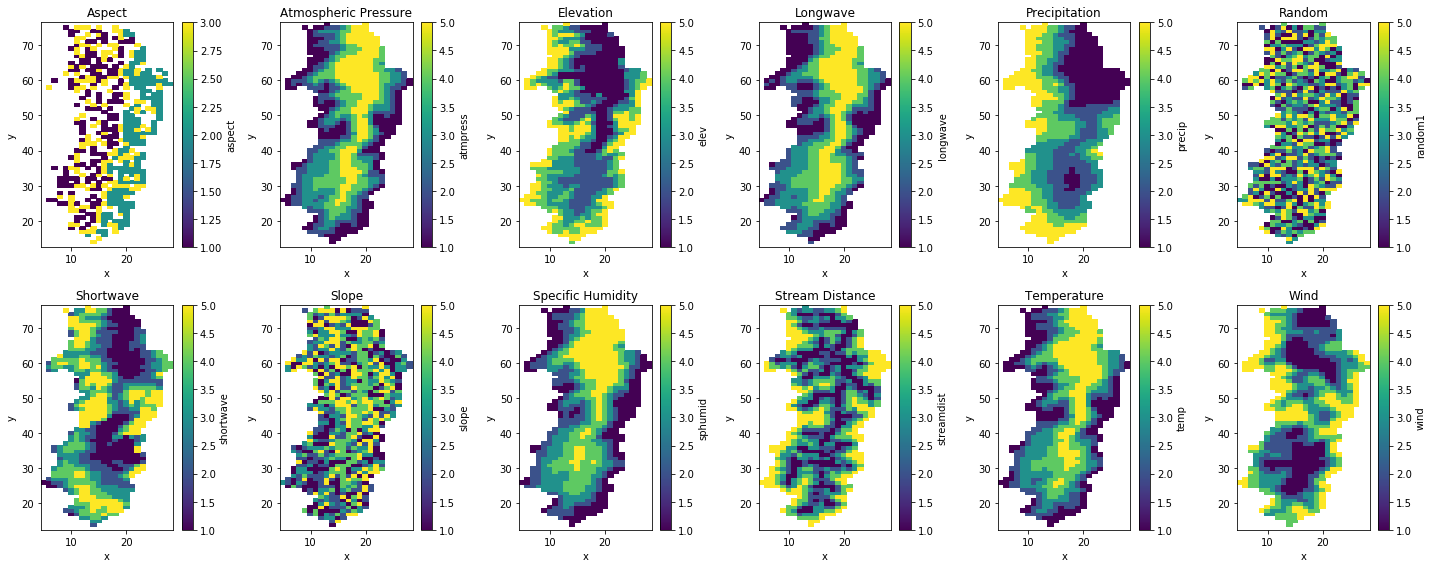

In [6]:
fig,ax = plt.subplots(nrows=2,ncols=6,figsize=[20,8])
ax = ax.flatten()

q.aspect.plot(ax=ax[0])
ax[0].set_title('Aspect')

q.atmpress.plot(ax=ax[1])
ax[1].set_title('Atmospheric Pressure')

q.elev.plot(ax=ax[2])
ax[2].set_title('Elevation')

q.longwave.plot(ax=ax[3])
ax[3].set_title('Longwave')

q.precip.plot(ax=ax[4])
ax[4].set_title('Precipitation')

q.random1.plot(ax=ax[5])
ax[5].set_title('Random')

q.shortwave.plot(ax=ax[6])
ax[6].set_title('Shortwave')

q.slope.plot(ax=ax[7])
ax[7].set_title('Slope')

q.sphumid.plot(ax=ax[8])
ax[8].set_title('Specific Humidity')

q.streamdist.plot(ax=ax[9])
ax[9].set_title('Stream Distance')

q.temp.plot(ax=ax[10])
ax[10].set_title('Temperature')

q.wind.plot(ax=ax[11])
ax[11].set_title('Wind')


plt.tight_layout()
plt.savefig('figs/exps.png',transparent=True)

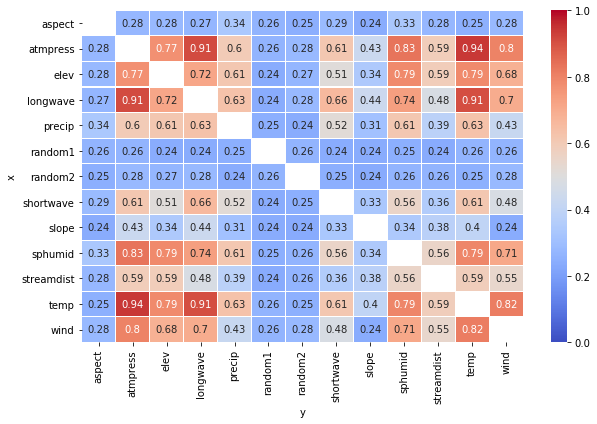

In [7]:
df = overlap_table(q)
df[df==1] = np.nan
dfpivot = df.pivot('x','y','overlap')
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(dfpivot, annot=True, linewidths=.1, ax=ax,cmap='coolwarm', vmin=0, vmax=1)
plt.tight_layout()
plt.savefig('figs/matx0.png',transparent=True)

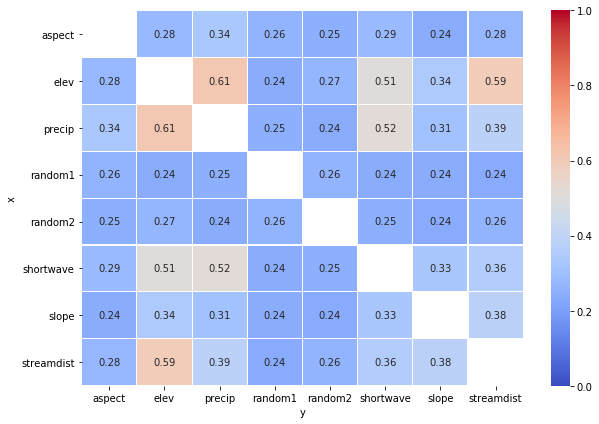

In [8]:
q1 = q.drop_vars(['atmpress','longwave','sphumid','temp','wind'])
df1 = overlap_table(q1)
df1[df1==1] = np.nan
df1pivot = df1.pivot('x','y','overlap')
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(df1pivot, annot=True, linewidths=.1, ax=ax,cmap='coolwarm', vmin=0, vmax=1)
plt.tight_layout()
plt.savefig('figs/matx1.png',transparent=True)

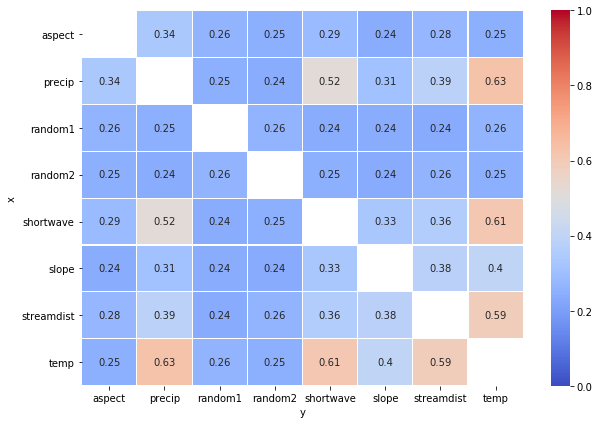

In [9]:
q1 = q.drop_vars(['atmpress','longwave','sphumid','elev','wind'])
df1 = overlap_table(q1)
df1[df1==1] = np.nan
df1pivot = df1.pivot('x','y','overlap')
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(df1pivot, annot=True, linewidths=.1, ax=ax,cmap='coolwarm', vmin=0, vmax=1)
plt.tight_layout()
plt.savefig('figs/matx2.png',transparent=True)

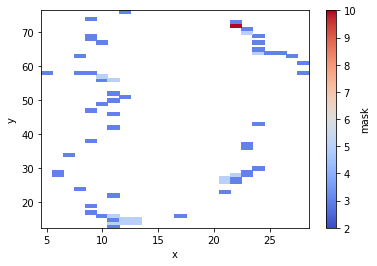

In [10]:
main = tc.mask.where(outflow.overlandsum==outflow.overlandsum.max(),0) * 10
feeders = err_trace.where(err_out==0,0) * 5
other = err_out * 3
ill = main + other + feeders
ill = ill.where(ill>0)
ill.plot(cmap='coolwarm',vmin=2);
plt.savefig('figs/outflow.png',transparent=True)

In [15]:
q.to_netcdf('experiments.nc')